In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session, sessionmaker
from sqlalchemy import create_engine, func, inspect, select
from datetime import timedelta, datetime

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

/var/folders/4g/9d537x513m58r8jcsl2t9jbc0000gn/T/ipykernel_40610/4196587217.py:4: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(engine, reflect=True)


In [6]:
# View all of the classes that automap found
Base.classes.keys()


['station', 'measurement']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

# tables = inspector.get_tables_names()
# Measurement = measurement.__table__
# Station = station.__table__



In [8]:
# Create our session (link) from Python to the DB
session = Session(bind=engine)

In [9]:
inspector = inspect(engine)

In [10]:
for x in inspector.get_columns("measurement"):
    print(x["name"], x["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [11]:
connection = engine.connect()
#connection.execute('SELECT * FROM measurement LIMIT 5').fetchall()


In [12]:
for x in inspector.get_columns("station"):
    print(x["name"], x["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Precipitation Analysis

In [13]:
# Find the most recent date in the data set.
session.query(Measurement.date).order_by(Measurement.date.desc()).first()

('2017-08-23',)

In [14]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
year_ago = dt.date(2017,8,23) - dt.timedelta(days= 365)
year_ago


datetime.date(2016, 8, 23)

In [15]:
# Perform a query to retrieve the data and precipitation scores
# end_date = datetime.now()
# start_date = end_date - timedelta(days=365)


# precip = session.query(Measurement.date, func.max(Measurement.prcp)) \
#                 .filter(Measurement.date >= start_date, Measurement.date <= end_date) \
#                 .group_by(Measurement.date) \
#                 .all()
# for date, precipitation in precip:
#     print(f"Date: {date}, Precipitation: {precipitation}")

# session.close()


precip = session.query(Measurement.date,func.max(Measurement.prcp)).\
    filter(func.strftime('%Y-%m-%d', Measurement.date)> year_ago).group_by(Measurement.date).all()


In [16]:
# Save the query results as a Pandas DataFrame. Explicitly set the column names
precip_df = pd.DataFrame(precip, columns= ['date', 'prcp'])
precip_df.set_index('date', inplace=True)
precip_df.head(15)

,prcp
date,
2016-08-24,2.28
2016-08-25,0.21
2016-08-26,0.04
2016-08-27,0.18
2016-08-28,2.07
2016-08-29,0.90
2016-08-30,0.05
2016-08-31,2.46
2016-09-01,0.02


In [17]:
# Sort the dataframe by date
precip_df.sort_values('date').head()


,prcp
date,
2016-08-24,2.28
2016-08-25,0.21
2016-08-26,0.04
2016-08-27,0.18
2016-08-28,2.07


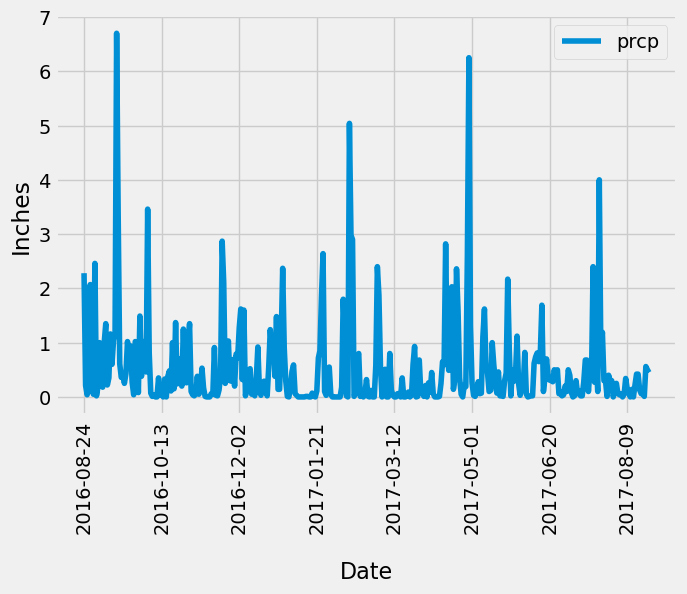

In [18]:
# Use Pandas Plotting with Matplotlib to plot the data
precip_df.plot(figsize=(7,5))
plt.tight_layout()
plt.xlabel("Date", fontsize =16, labelpad=20)
plt.ylabel("Inches")
plt.xticks(rotation=90)
plt.show()

In [19]:
# Use Pandas to calculate the summary statistics for the precipitation data
precip_df.describe()

,prcp
count,365.000000
mean,0.517288
std,0.829196
min,0.000000
25%,0.040000
50%,0.250000
75%,0.650000
max,6.700000


# Exploratory Station Analysis

In [20]:
# Design a query to calculate the total number of stations in the dataset
session.query(Measurement.station).distinct().count()

9

In [21]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
station_counts = session.query(Measurement.station, func.count(Measurement.station).label('observation_count')) \
                        .group_by(Measurement.station) \
                        .order_by(func.count(Measurement.station).desc()) \
                        .all()
station_counts

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [22]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
lowest_highest_avg = session.query(func.min(Measurement.tobs),
                        func.max(Measurement.tobs),
                        func.avg(Measurement.tobs)).\
                        filter(Measurement.station == 'USC00519281').all()
lowest_highest_avg


[(54.0, 85.0, 71.66378066378067)]

In [23]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
twelve_months_temp = session.query(Measurement.tobs).\
                filter(Measurement.date >= year_ago, Measurement.station == 'USC00519281').\
                order_by(Measurement.tobs).all()
#twelve_months_temp


df_twelve_months_temp = pd.DataFrame(twelve_months_temp, columns=['Tobs'])
df_twelve_months_temp.head()

,Tobs
0,59.0
1,59.0
2,59.0
3,60.0
4,60.0


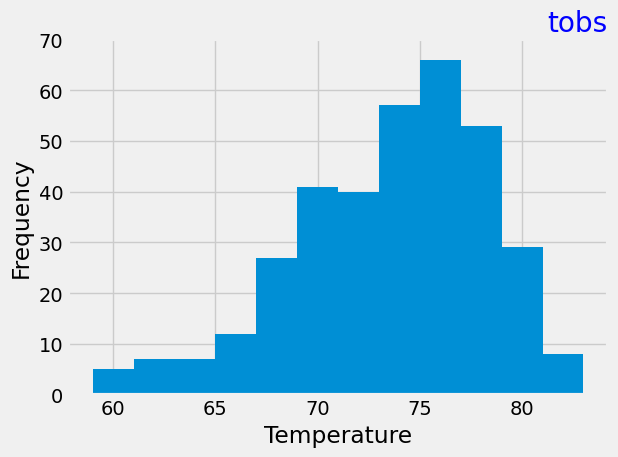

In [24]:
bins = 12
df_twelve_months_temp['Tobs'].plot.hist(bins=bins)
plt.ylim(0, 70)
plt.xlabel("Temperature")
plt.ylabel("Frequency")
title = plt.title("tobs", loc='right')
title.set_color('blue')
#title.set_pad(20)
#plt.title(f'Temperature Observations for Station {most_active_station_id} (Last 12 Months)')
plt.tight_layout()
#plt.savefig('Images/station-histogram.png')

plt.show()

# Close Session

In [25]:
# Close Session
session.close()